In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-26 17:41:56 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-26 17:41:56 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-26 17:41:56 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-26 17:41:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-26 17:41:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-26 17:41:59 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-26 17:41:59 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-26 17:42:00 src.models WARNING  Qwen/Qwen2.5-72B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-26 17:42:00 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-26 17:42:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/config.json HTTP/1.1" 307 0
2025-08-26 17:42:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-72B-Instruct/495f39366efef23836d0cfae4fbe635880d2be31/config.json HTTP/1.1" 200 0
2025-08-26 17:42:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 307 0
2025-08-26 17:42:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-72B-Instruct/495f39366efef23836d0cfae4fbe635880d2be31/tokenizer_config.json HTTP/1.1" 200 0
2025-08-26 17:42:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/Qwen/Qwen2.5-72B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/37 [00:00<?, ?it/s]

2025-08-26 17:42:44 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/generation_config.json HTTP/1.1" 307 0
2025-08-26 17:42:44 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-72B-Instruct/495f39366efef23836d0cfae4fbe635880d2be31/generation_config.json HTTP/1.1" 200 0
2025-08-26 17:42:44 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-72B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-26 17:42:44 src.models INFO     loaded model <Qwen/Qwen2.5-72B-Instruct> | size: 138676.078 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [7]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [8]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Watermelon -> Banana (2): ['Spruce', 'Airplane', 'Banana', 'Coffee maker', 'Dumbbell', 'Tablet']
Options: Spruce, Airplane, Banana, Coffee maker, Dumbbell, Tablet.
Which among these objects mentioned above is a fruit?
Answer:


In [9]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Spruce, Airplane, Banana, Coffee maker, Dumbbell, Tablet.
Which among these objects mentioned above is a fruit?
Answer:" >> Banana


(True,
 [PredictedToken(token=' Banana', prob=0.70703125, logit=28.0, token_id=75824, metadata=None),
  PredictedToken(token=' The', prob=0.1572265625, logit=26.5, token_id=576, metadata=None),
  PredictedToken(token=' Among', prob=0.07421875, logit=25.75, token_id=21658, metadata=None),
  PredictedToken(token=' \n', prob=0.039794921875, logit=25.125, token_id=715, metadata=None),
  PredictedToken(token=' \n\n', prob=0.012939453125, logit=24.0, token_id=4710, metadata=None)],
 OrderedDict([(75824,
               (1,
                PredictedToken(token=' Banana', prob=0.70703125, logit=28.0, token_id=75824, metadata=None))),
              (57303,
               (89,
                PredictedToken(token=' Tablet', prob=2.4400651454925537e-07, logit=13.125, token_id=57303, metadata=None))),
              (422,
               (105,
                PredictedToken(token=' D', prob=1.3969838619232178e-07, logit=12.5625, token_id=422, metadata=None))),
              (26079,
               (18

In [10]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Banana

Among the objects listed, the banana is the only fruit. It is a popular edible fruit" >> Banana


In [11]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [12]:
# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

HEADS = [(62, 1), (60, 9), (64, 8), (62, 0), (62, 45), (59, 59), (71, 28), (64, 12), (61, 7), (64, 13), (67, 53), (67, 51), (54, 44), (57, 5), (59, 60)]

# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

15


2025-08-26 17:43:31 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-26 17:43:31 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-08-26 17:43:31 matplotlib DEBUG    interactive is False
2025-08-26 17:43:31 matplotlib DEBUG    platform is linux
2025-08-26 17:43:31 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-08-26 17:43:31 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-08-26 17:43:32 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-26 17:43:32 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-26 17:43:32 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-26 17:43:32 matplotlib.font

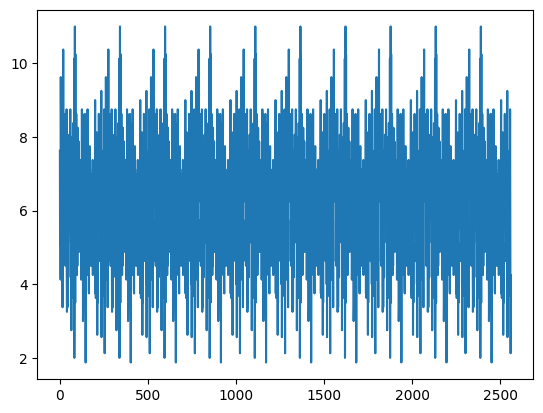

In [13]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "distinct_options",
    f"{select_task.task_name}",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

3200


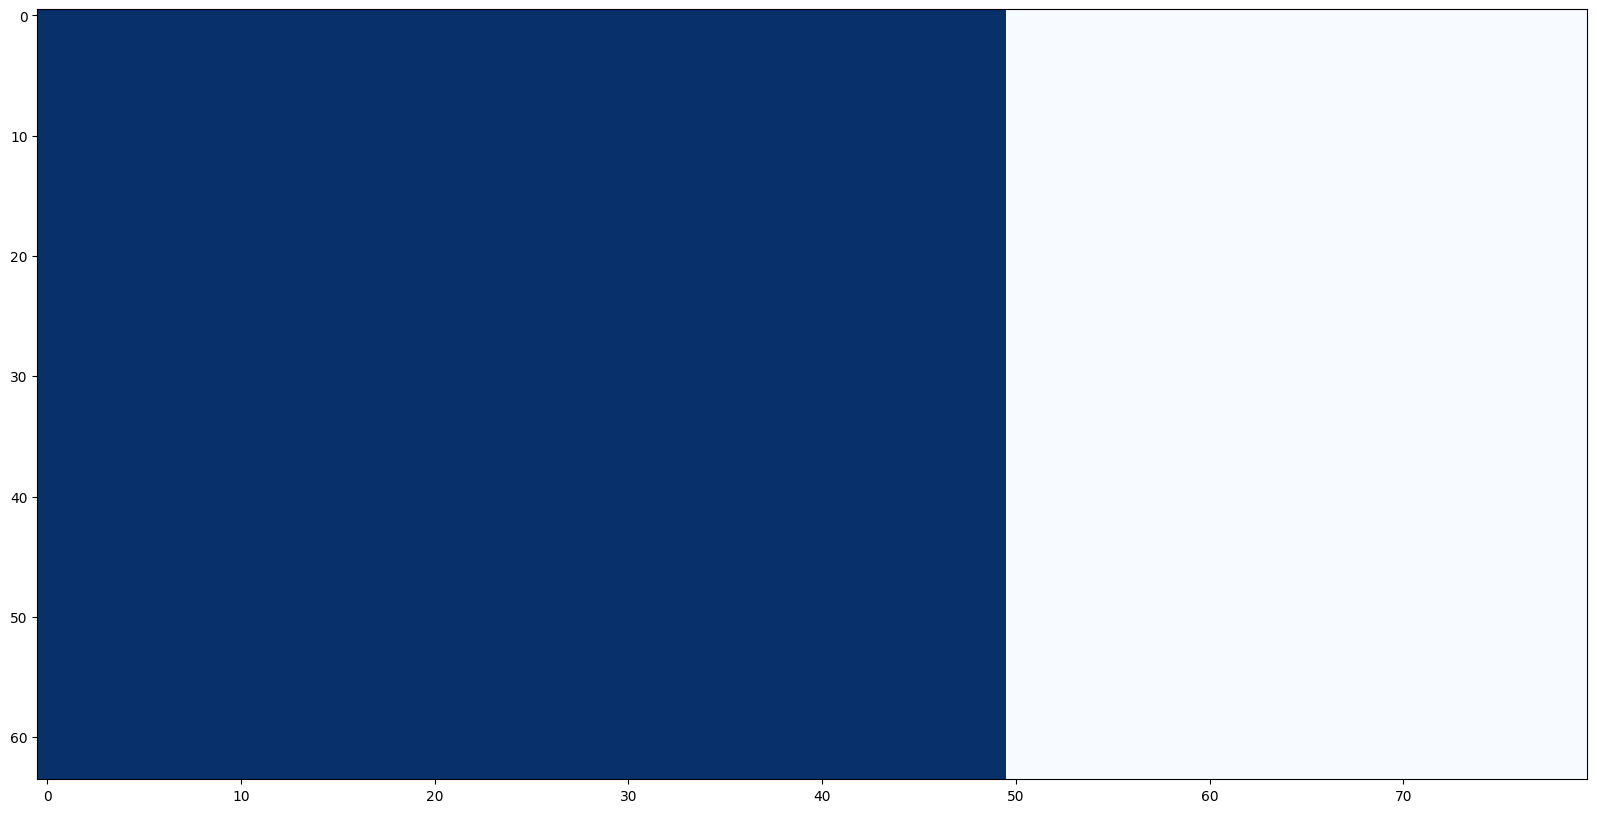

In [14]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected
]
print(len(heads_selected))

# HEADS = heads_selected

# (35, 19) in HEADS, (35, 19) in heads_selected

In [15]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

0 patches to ablate possible answer information from options
2025-08-26 17:43:41 src.selection.functional DEBUG    Predictions: ['" Banana"[75824] (p=0.707, logit=28.000)', '" The"[576] (p=0.157, logit=26.500)', '" Among"[21658] (p=0.074, logit=25.750)', '" \n"[715] (p=0.040, logit=25.125)', '" \n\n"[4710] (p=0.013, logit=24.000)']
2025-08-26 17:43:41 src.selection.functional INFO     Combined attention matrix for all heads


In [16]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    option_style="numbered",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=n_distractors - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    kwargs = dict(
        prompt_template=task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )
    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        **kwargs,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        **kwargs,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [17]:
type(select_task)

src.selection.data.SelectOneTask

In [18]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    n_distractors=5,
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

clean_sample.metadata

2025-08-26 17:43:52 __main__ INFO     Patch category: fruit, subject: Pear, object: Apple
2025-08-26 17:43:52 __main__ INFO     Clean category: vehicle, subject: Bike, object: Yacht
2025-08-26 17:43:52 __main__ INFO     patch_must_have_options=['Apple', 'Van']
2025-08-26 17:43:52 __main__ INFO     clean_must_have_options=['Yacht', 'Cherry']
2025-08-26 17:43:52 __main__ INFO     clean_type_obj='Van'
2025-08-26 17:43:52 __main__ INFO     patch_type_obj='Cherry'
2025-08-26 17:43:52 __main__ INFO     patch_obj_idx=2 | ['Warehouse', 'Van', 'Apple', 'Keyboard', 'Lily', 'Saxophone']


2025-08-26 17:43:52 __main__ INFO     clean_obj_idx=1 | ['Refrigerator', 'Yacht', 'Cherry', 'School', 'Horse', 'Ring']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-26 17:43:52 __main__ INFO     Options: Warehouse, Van, Apple, Keyboard, Lily, Saxophone.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-26 17:43:52 __main__ INFO     Pear | fruit -> Apple | pred=['" Apple"[8162] (p=0.766, logit=32.750)', '" The"[576] (p=0.150, logit=31.125)', '" Among"[21658] (p=0.055, logit=30.125)', '" \n"[715] (p=0.023, logit=29.250)', '" \n\n"[4710] (p=0.003, logit=27.125)']
2025-08-26 17:43:52 __main__ INFO     Options: Refrigerator, Yacht, Cherry, School, Horse, Ring.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-26 17:43:52 __main__ INFO     Bike | vehicle -> Yacht | pred=['" Y"[809] (p=0.887, logit=29.750)', '" The"[576] (p=0.073, logit=27.250)', '" Among"[21658] (p=0.016, logit=25.750)', '" \n"[715] (p=0.009, logit=25.125)', '" A"[362

{'track_category': 'fruit',
 'track_type_obj': 'Cherry',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 44705,
 'tokenized': {'input_ids': tensor([[ 3798,    25, 74158,   850,    11,   809, 15938,    11, 44705,    11,
            6022,    11, 33292,    11, 21525,   624, 23085,  4221,  1493,  6171,
            9733,  3403,   374,   264,  7310,  5267, 16141,    25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1]], device='cuda:0')}}

In [19]:
# order_sample_1 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Bike", "Apple", "Bed", "Dog", "Monitor", "Theater"],
#     obj="Apple",
#     obj_idx=1,
#     prompt_template="<_options_>\nWhat is the third item in the list?\nAnswer:",
#     answer="Apple",
# )

# order_sample_2 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Cat", "Chair", "Bus", "Phone", "Library", "Orange"],
#     obj="Phone",
#     obj_idx=3,
#     prompt_template="<_options_>\nWhat is the fifth item in the list?\nAnswer:",
#     answer="Phone",
# )
len(HEADS)

15

In [20]:
from src.functional import generate_with_patch

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj
for sample in [patch_sample, clean_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-1
    )

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Warehouse, Van, Apple, Keyboard, Lily, Saxophone.
Which among these objects mentioned above is a fruit?
Answer: >> Apple
0 patches to ablate possible answer information from options
2025-08-26 17:44:00 src.selection.functional DEBUG    Generated full answer: " Apple

Among the options provided—Warehouse, Van, Apple, Keyboard, Lily, and Saxophone—the object that is a fruit is the Apple."
2025-08-26 17:44:00 src.selection.functional DEBUG    Predictions: ['" Apple"[8162] (p=0.766, logit=32.750)', '" The"[576] (p=0.150, logit=31.125)', '" Among"[21658] (p=0.055, logit=30.125)', '" \n"[715] (p=0.023, logit=29.250)', '" \n\n"[4710] (p=0.003, logit=27.125)']
2025-08-26 17:44:00 src.selection.functional INFO     Combined attention matrix for all heads


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Refrigerator, Yacht, Cherry, School, Horse, Ring.
Which among these objects mentioned above is a vehicle?
Answer: >> Yacht
0 patches to ablate possible answer information from options
2025-08-26 17:44:06 src.selection.functional DEBUG    Generated full answer: " Yacht

A yacht is a vehicle, specifically a type of watercraft used for pleasure and often for racing or cruising. The other items listed ("
2025-08-26 17:44:06 src.selection.functional DEBUG    Predictions: ['" Y"[809] (p=0.887, logit=29.750)', '" The"[576] (p=0.073, logit=27.250)', '" Among"[21658] (p=0.016, logit=25.750)', '" \n"[715] (p=0.009, logit=25.125)', '" A"[362] (p=0.006, logit=24.750)']
2025-08-26 17:44:06 src.selection.functional INFO     Combined attention matrix for all heads


In [21]:
clean_sample.metadata

{'track_category': 'fruit',
 'track_type_obj': 'Cherry',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 44705,
 'tokenized': {'input_ids': tensor([[ 3798,    25, 74158,   850,    11,   809, 15938,    11, 44705,    11,
            6022,    11, 33292,    11, 21525,   624, 23085,  4221,  1493,  6171,
            9733,  3403,   374,   264,  7310,  5267, 16141,    25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1]], device='cuda:0')}}

In [22]:
patch_sample.obj_idx

2

## Testing patching the query projection of a single head

In [23]:
import baukit
from src.functional import get_module_nnsight, PatchSpec
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
from typing import Literal
from src.tokens import prepare_input


def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
    mt.config._attn_implementation = attn_implementation
    for layer_idx in range(mt.config.num_hidden_layers):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.config._attn_implementation = attn_implementation


###################################################################################
batch_size = 1  # tokenized.input_ids.shape[0]
n_heads = mt.config.num_attention_heads
head_dim = mt.n_embd // n_heads
query_idx = -1 # almost always the last token
###################################################################################

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(block_name=attn_block_name),
    attn_block,
)

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
patch_seq_len = patch_tokenized.input_ids.shape[1]
input_ln = mt.layer_name_format.format(layer_idx) + ".input_layernorm"

with mt.trace(patch_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    patch_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    patch_q_proj = q_proj_module.output.view(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # patch_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=patch_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
clean_seq_len = clean_tokenized.input_ids.shape[1]
with mt.trace(clean_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    clean_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    clean_q_proj = q_proj_module.output.view(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # clean_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=clean_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

mt.reset_forward()
set_attn_implementation(mt, "eager")

patch_q_proj.shape, clean_q_proj.shape, patch_ln.shape, clean_ln.shape

2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    hidden_shape=(1, 28, -1, 128) | input_shape=torch.Size([1, 28]) | torch.Size([1, 28, 8192])
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 28, 128]) | key_states.size()=torch.Size([1, 8, 28, 128]) | value_states.size()=torch.Size([1, 8, 28, 128])
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    hidden_shape=(1, 33, -1, 128) | input_shape=torch.Size([1, 33]) | torch.Size([1, 33, 8192])
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 33, 128]) | key_states.size()=torch.Size([1, 8, 33, 128]) | value_states.size()=torch.Size([1, 8, 33, 128])


(torch.Size([1, 64, 28, 128]),
 torch.Size([1, 64, 33, 128]),
 torch.Size([1, 28, 8192]),
 torch.Size([1, 33, 8192]))

In [27]:
from src.attention import visualize_attn_matrix
from src.functional import get_hs, interpret_logits

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = 35, 19

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

2025-08-11 10:38:24 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:38:24 src.hooking.llama_attention DEBUG    hidden_shape=(1, 33, -1, 128) | input_shape=torch.Size([1, 33]) | torch.Size([1, 33, 8192])
2025-08-11 10:38:24 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 33, 128]) | key_states.size()=torch.Size([1, 8, 33, 128]) | value_states.size()=torch.Size([1, 8, 33, 128])


([PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.060302734375, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.04150390625, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03662109375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.00634765625, logit=17.5, token_id=423, metadata=None)],
 {15429: (38,
   PredictedToken(token=' Hospital', prob=0.0001163482666015625, logit=13.5, token_id=15429, metadata=None))})

In [28]:
clean_sample.metadata

{'track_category': 'building',
 'track_type_obj': 'Hospital',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 15429}

In [29]:
from src.attention import visualize_attn_matrix

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
        query_patches=[[head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].squeeze()]],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
patch_logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

2025-08-11 10:38:26 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:38:26 src.hooking.llama_attention DEBUG    hidden_shape=(1, 33, -1, 128) | input_shape=torch.Size([1, 33]) | torch.Size([1, 33, 8192])
2025-08-11 10:38:26 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 33, 128]) | key_states.size()=torch.Size([1, 8, 33, 128]) | value_states.size()=torch.Size([1, 8, 33, 128])


([PredictedToken(token=' Dress', prob=0.8359375, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.053466796875, logit=19.625, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.041748046875, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.036865234375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.004974365234375, logit=17.25, token_id=423, metadata=None)],
 {15429: (6,
   PredictedToken(token=' Hospital', prob=0.00341796875, logit=16.875, token_id=15429, metadata=None))})

In [30]:
# torch.allclose(patch_logits, logits, atol = 1e-3)

In [31]:
# torch.allclose(
#     patch_q_proj[:, head_idx, query_idx, :], 
#     clean_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [32]:
# torch.allclose(
#     patch_ln[:, query_idx, :], 
#     clean_ln[:, query_idx, :],
#     atol=1e-3
# )

In [33]:
# patch_ln[:, query_idx, :], clean_ln[:, query_idx, :]

In [34]:
# # manual calculation
# attn_module = baukit.get_module(mt._model, mt.attn_module_name_format.format(layer_idx))
# patch_q_proj_manual = attn_module.q_proj(patch_ln)
# clean_q_proj_manual = attn_module.q_proj(clean_ln)

# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)
# print(torch.allclose(
#     patch_q_proj_manual[:, query_idx, :], 
#     clean_q_proj_manual[:, query_idx, :],
#     atol=1e-3
# ))

# patch_q_proj_manual = patch_q_proj_manual.reshape(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2)
# clean_q_proj_manual = clean_q_proj_manual.reshape(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2)
# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)

# for idx in range(n_heads):
#     print(head_idx, torch.allclose(
#         patch_q_proj_manual[:, idx, query_idx, :], 
#         clean_q_proj_manual[:, idx, query_idx, :],
#         atol=1e-3
#     ))

In [35]:
# torch.allclose(
#     patch_q_proj_manual[:, head_idx, query_idx, :], 
#     patch_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [36]:
replace_q_proj = clean_q_proj.clone()
replace_q_proj[:, head_idx, query_idx, :] = patch_q_proj[:, head_idx, query_idx, :]

print(torch.allclose(
        replace_q_proj[:, head_idx, query_idx, :],
        clean_q_proj[:, head_idx, query_idx, :],
        atol=1e-3
    )
)
print(replace_q_proj.shape)

replace_q_proj = replace_q_proj.transpose(1, 2).reshape(batch_size, clean_seq_len, -1)

rep_patch = PatchSpec(
    location=(q_proj_name, -1),
    patch=replace_q_proj[:, -1, :].squeeze(),
)

ln_patch = PatchSpec(
    location=(input_ln, -1),
    patch=patch_ln[:, query_idx, :].squeeze(),
)

head_q_patch = PatchSpec(
    location=(q_proj_name, head_idx, -1),
    patch=patch_q_proj[:, head_idx, query_idx, :].squeeze(),
)

head_q_patch.location, rep_patch.location

False
torch.Size([1, 64, 33, 128])


(('model.layers.35.self_attn.q_proj', 19, -1),
 ('model.layers.35.self_attn.q_proj', -1))

In [37]:
# clean_q_proj_rs = clean_q_proj.view(batch_size, clean_seq_len, -1)
# patch_q_proj_rs = patch_q_proj.view(batch_size, clean_seq_len, -1)
# clean_q_proj_rs[:, -1, :].shape, patch_q_proj_rs[:, -1, :].shape

In [38]:
# torch.allclose(
#     replace_q_proj[:, -1, :].squeeze(), 
#     # patch_q_proj_rs[:, -1, :].squeeze(),
#     clean_q_proj_rs[:, -1, :].squeeze(), 
#     atol=1e-3
# )

In [39]:
patch_q_proj.shape, clean_q_proj.shape
# torch.allclose(patch_q_proj.patch, clean_q_proj.patch)

(torch.Size([1, 64, 28, 128]), torch.Size([1, 64, 33, 128]))

In [40]:
clean_sample.metadata

{'track_category': 'building',
 'track_type_obj': 'Hospital',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 15429}

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
)

attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

([PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.060302734375, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.041259765625, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03662109375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.00634765625, logit=17.5, token_id=423, metadata=None)],
 {29318: (1,
   PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None)),
  15429: (38,
   PredictedToken(token=' Hospital', prob=0.0001163482666015625, logit=13.5, token_id=15429, metadata=None))})

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

patched_attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    # patches=[ln_patch],
    patches = [head_q_patch],
    # patches = [rep_patch],
    # patch_interface=patch_with_nnsight
    patch_interface=patch_with_baukit
)

patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=patched_attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patched_attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

([PredictedToken(token=' Dress', prob=0.84765625, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.0478515625, logit=19.5, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.042236328125, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03271484375, logit=19.125, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.005035400390625, logit=17.25, token_id=423, metadata=None)],
 {29318: (1,
   PredictedToken(token=' Dress', prob=0.84765625, logit=22.375, token_id=29318, metadata=None)),
  15429: (6,
   PredictedToken(token=' Hospital', prob=0.0030517578125, logit=16.75, token_id=15429, metadata=None))})

## Patching a bunch of heads

### Loading the Heads

#### Attention Behavior

In [23]:
from scripts.locate_via_attention_behavior import SelectionSampleAttn

In [25]:
attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns/select_one",
    mt.name.split("/")[-1],
    "objects"
)
files = sorted(os.listdir(attn_path))
print(files)

#######################################################################
# LIMIT = 100
LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in files[:LIMIT]:
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 100 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns)

['sample_0000.npz', 'sample_0001.npz', 'sample_0002.npz', 'sample_0003.npz', 'sample_0004.npz', 'sample_0005.npz', 'sample_0006.npz', 'sample_0007.npz', 'sample_0008.npz', 'sample_0009.npz', 'sample_0010.npz', 'sample_0011.npz', 'sample_0012.npz', 'sample_0013.npz', 'sample_0014.npz', 'sample_0015.npz', 'sample_0016.npz', 'sample_0017.npz', 'sample_0018.npz', 'sample_0019.npz', 'sample_0020.npz', 'sample_0021.npz', 'sample_0022.npz', 'sample_0023.npz', 'sample_0024.npz', 'sample_0025.npz', 'sample_0026.npz', 'sample_0027.npz', 'sample_0028.npz', 'sample_0029.npz', 'sample_0030.npz', 'sample_0031.npz', 'sample_0032.npz', 'sample_0033.npz', 'sample_0034.npz', 'sample_0035.npz', 'sample_0036.npz', 'sample_0037.npz', 'sample_0038.npz', 'sample_0039.npz', 'sample_0040.npz', 'sample_0041.npz', 'sample_0042.npz', 'sample_0043.npz', 'sample_0044.npz', 'sample_0045.npz', 'sample_0046.npz', 'sample_0047.npz', 'sample_0048.npz', 'sample_0049.npz', 'sample_0050.npz', 'sample_0051.npz', 'sample_005

2048

In [27]:
from src.attention import visualize_attn_matrix

sample_idx = 345
# layer_idx = 39
# head_idx = 40
layer_idx = 54
head_idx = 44

selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(0.269134521484375, 0.470703125, [0.0043926239013671875, 0.00213623046875, 0.0005407333374023438, 0.201568603515625, 0.006961822509765625])


In [28]:
from tqdm.auto import tqdm

#############################################################################
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/2048 [00:00<?, ?it/s]

torch.Size([64, 80])

2025-08-26 17:04:15 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f27a80e0bd0>


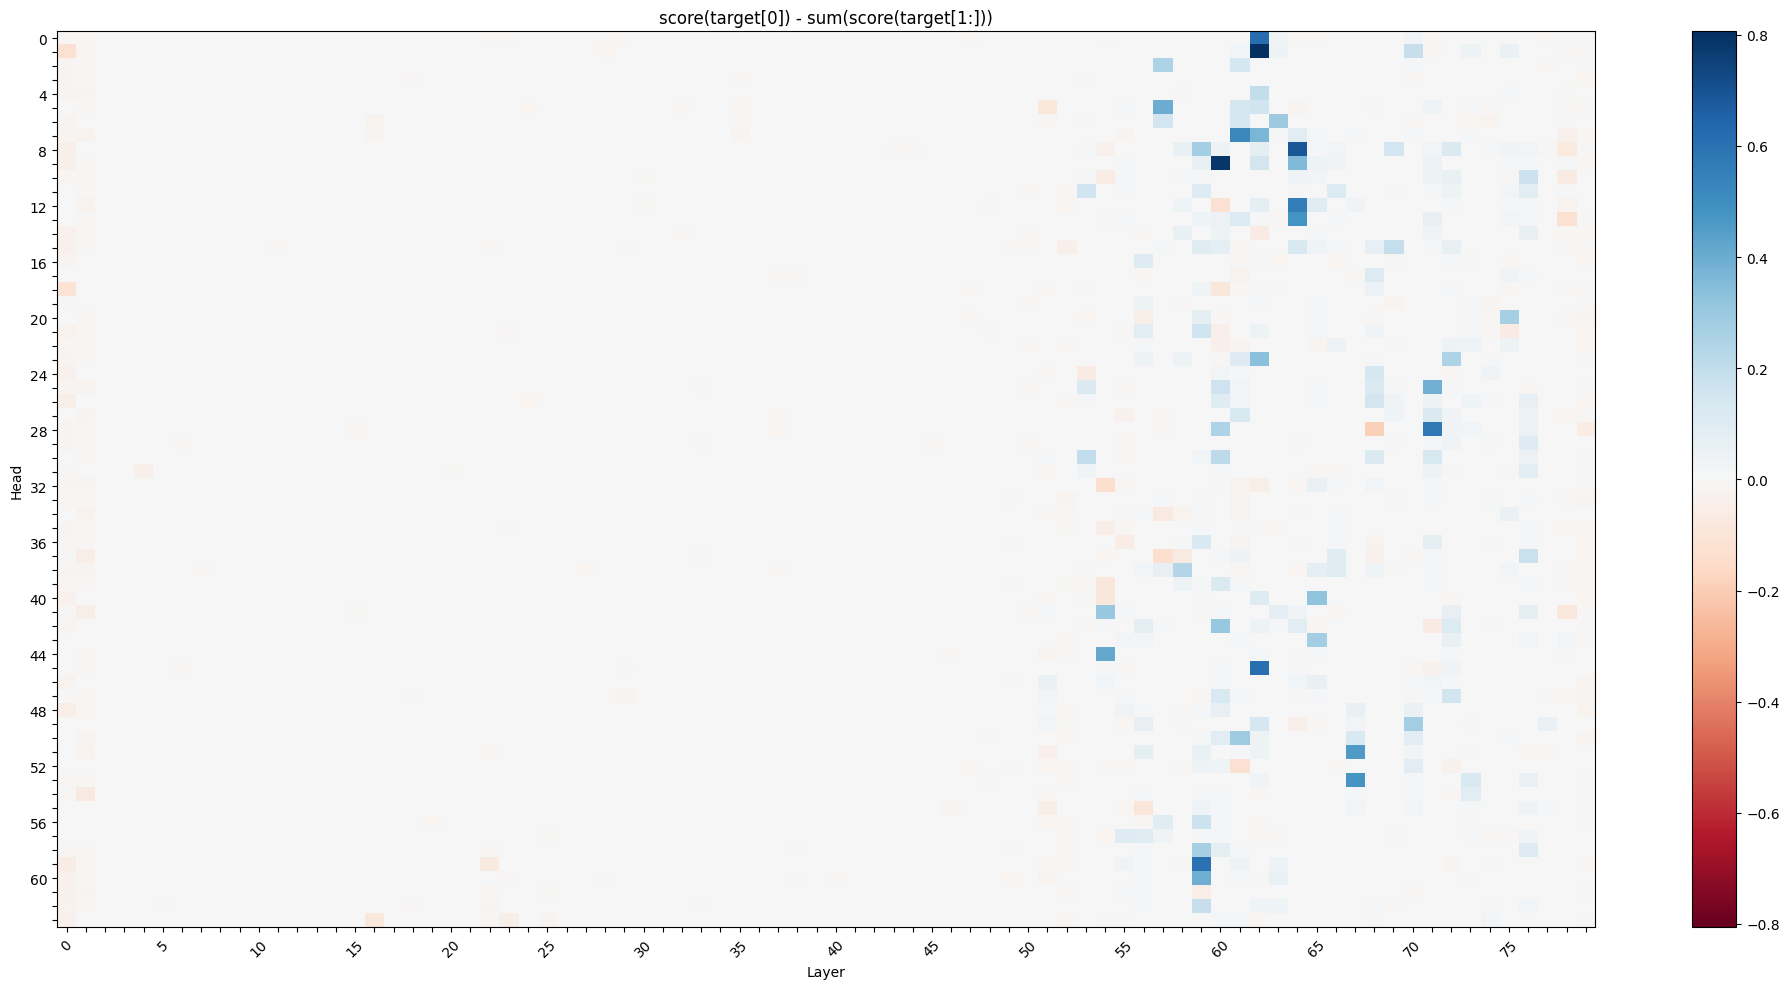

Layer 62, Head 1: 0.8061
Layer 60, Head 9: 0.7835
Layer 64, Head 8: 0.6922
Layer 62, Head 0: 0.6163
Layer 62, Head 45: 0.6103
Layer 59, Head 59: 0.6028
Layer 71, Head 28: 0.5789
Layer 64, Head 12: 0.5582
Layer 61, Head 7: 0.5225
Layer 64, Head 13: 0.4823
Layer 67, Head 53: 0.4784
Layer 67, Head 51: 0.4590
Layer 54, Head 44: 0.4103
Layer 57, Head 5: 0.3988
Layer 59, Head 60: 0.3927


In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [31]:
HEADS = [(layer_idx, head_idx) for head_idx, layer_idx, score in scores_per_head[:100]]
print(HEADS)

[(62, 1), (60, 9), (64, 8), (62, 0), (62, 45), (59, 59), (71, 28), (64, 12), (61, 7), (64, 13), (67, 53), (67, 51), (54, 44), (57, 5), (59, 60), (71, 25), (62, 7), (64, 9), (62, 23), (65, 40), (54, 41), (60, 42), (63, 6), (61, 50), (70, 49), (59, 8), (65, 43), (59, 58), (75, 20), (60, 28), (57, 2), (72, 23), (58, 38), (60, 30), (62, 4), (53, 30), (69, 15), (70, 1), (59, 62), (76, 37), (59, 56), (76, 10), (60, 25), (53, 11), (62, 5), (59, 21), (69, 8), (57, 6), (72, 47), (68, 26), (62, 9), (61, 2), (68, 24), (62, 49), (61, 5), (61, 6), (71, 30), (67, 50), (59, 36), (64, 15), (61, 27), (73, 53), (60, 47), (68, 25), (71, 27), (72, 8), (60, 39), (53, 25), (68, 30), (72, 42), (66, 11), (68, 17), (61, 13), (55, 57), (56, 16), (61, 23), (76, 29), (76, 58), (62, 40), (59, 11), (65, 12), (56, 57), (66, 37), (60, 26), (57, 56), (59, 15), (66, 38), (60, 50), (76, 11), (76, 31), (64, 42), (73, 54), (70, 50), (56, 21), (64, 7), (70, 52), (56, 51), (60, 58), (65, 38), (59, 20)]


#### Based on Patching Score

In [48]:
from scripts.patching_within_task import SelectionQprojPatchResult
from tqdm.auto import tqdm


q_proj_root = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/q_states_patching",
    # mt.name.split("/")[-1],
    mt.name.replace("72B", "3B").split("/")[-1],
)

#############################################
LIMIT = 20
# LIMIT = None
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
categories = [
    # "profession",
    # "nationality",
    "objects",
]
#############################################

q_proj_results = {cat: [] for cat in categories}

for category in categories:
    print(f"category: {category}")
    q_proj_path = os.path.join(q_proj_root, category)
    files = sorted(os.listdir(q_proj_path))
    LIMIT = LIMIT or len(files)
    q_proj_results[category] = []
    for file in tqdm(files[:LIMIT]):
        if not file.endswith(".json"):
            continue

        file_path = os.path.join(q_proj_path, file)
        q_proj_results[category].append(SelectionQprojPatchResult.load_from_json(file_path))
        # if len(q_proj_results) % 10 == 0:
        #     print(f"Loaded {len(q_proj_results)}/{LIMIT} files")



category: objects


  0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
import copy
combine_all_results = []
for category in categories:
    combine_all_results.extend(q_proj_results[category])

results_copy = copy.deepcopy(q_proj_results)
results_copy["all"] = combine_all_results

In [51]:
len(results_copy["objects"])

3

In [52]:
from matplotlib import pyplot as plt

n_layer = mt.n_layer
n_heads = mt.config.num_attention_heads

category_wise_heads = {}
for category, categorywise_result in results_copy.items():
    indirect_effects = torch.zeros((n_layer, n_heads), dtype=torch.float32)
    for layer_idx in range(mt.n_layer):
        for head_idx in range(mt.config.num_attention_heads):
            indirect_effects[layer_idx, head_idx] = torch.mean(
                torch.tensor(
                    [
                        sample_result.head_effect(layer_idx, head_idx)
                        for sample_result in categorywise_result
                    ]
                )
            )

    plt.figure(figsize=(20, 10))
    scale = torch.max(torch.abs(indirect_effects))
    plt.imshow(
        indirect_effects.T.cpu().numpy(),
        cmap="RdBu",
        aspect="auto",
        vmin=-scale,
        vmax=scale,
    )
    plt.colorbar()
    # plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
    plt.title("IE of q_proj patching | " + category)
    plt.xlabel("Layer")
    plt.ylabel("Head")

    def get_ticks(ticks, skip=5):
        ret = []
        for i in ticks:
            if i % skip == 0:
                ret.append(str(i))
            else:
                ret.append("")
        return ret

    plt.xticks(
        ticks=range(n_layer),
        labels=get_ticks(range(n_layer)),
        rotation=45,
    )
    plt.yticks(
        ticks=range(n_head),
        labels=get_ticks(range(n_head), skip=4),
    )

    plt.tight_layout()
    plt.show()


    scores_per_head = []
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            scores_per_head.append(
                (layer_idx, head_idx, indirect_effects[layer_idx, head_idx].item())
            )

    scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
    category_wise_heads[category] = scores_per_head
    for layer_idx, head_idx, score in scores_per_head[:15]:
        print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

with open("category_wise_heads.json", "w") as f:
    json.dump(category_wise_heads, f, indent=4)

KeyError: (0, 16)

#### Performing the Patch

In [32]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:50]
# ]

# HEADS = heads_selected

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# category_wise_heads["all"][len(HEADS) - 1]

In [28]:
from src.utils.typing import TokenizerOutput


@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    query_locations: list[tuple[int, int, int]],  # (layer_idx, head_idx, query_idx)
    return_output: bool = False,
):
    layer_to_hq = {}
    for layer_idx, head_idx, query_idx in query_locations:
        if layer_idx not in layer_to_hq:
            layer_to_hq[layer_idx] = []
        layer_to_hq[layer_idx].append((head_idx, query_idx))

    q_projections = {}
    batch_size = input.input_ids.shape[0]
    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    head_dim = mt.n_embd // n_heads
    with mt.trace(input) as tracer:
        for layer_idx, query_locs in layer_to_hq.items():
            q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_proj_out = q_proj_module.output.view(
                batch_size, seq_len, n_heads, head_dim
            ).transpose(1, 2)
            for head_idx, query_idx in query_locs:
                q_projections[(layer_idx, head_idx, query_idx)] = (
                    q_proj_out[:, head_idx, query_idx, :].squeeze().save()
                )

        if return_output:
            output = mt.output.save()

    if return_output:
        return q_projections, output
    return q_projections

In [51]:
query_indices = list(range(-3, 0))
query_locations = [
    (layer_idx, head_idx, query_idx)
    for layer_idx, head_idx in HEADS
    for query_idx in query_indices
]

cached_q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
)

# cached_q_states[(HEADS[0])].shape

In [52]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

# attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
# )

# layer_idx, head_idx = 35, 19
# attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    generate_full_answer=True,
)

attn_pattern["predictions"]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-13 18:15:22 src.experiments.utils DEBUG    Generated full answer: " Submarine.
Explanation: A submarine is a type of underwater vehicle that is used for various purposes, including military, scientific research, and exploration. It"
2025-08-13 18:15:22 src.experiments.utils DEBUG    Predictions: ['" Sub"[3804] (p=0.758, logit=21.375)', '" A"[362] (p=0.116, logit=19.500)', '" The"[578] (p=0.055, logit=18.750)', '" Among"[22395] (p=0.029, logit=18.125)', '" It"[1102] (p=0.008, logit=16.875)']
2025-08-13 18:15:22 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Sub', prob=0.7578125, logit=21.375, token_id=3804, metadata=None),
 PredictedToken(token=' A', prob=0.11572265625, logit=19.5, token_id=362, metadata=None),
 PredictedToken(token=' The', prob=0.0546875, logit=18.75, token_id=578, metadata=None),
 PredictedToken(token=' Among', prob=0.029296875, logit=18.125, token_id=22395, metadata=None),
 PredictedToken(token=' It', prob=0.0084228515625, logit=16.875, token_id=1102, metadata=None)]

In [53]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit, PatchSpec

q_proj_patches = []
for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, query_idx),
            patch=q_proj
        )
    )

# patched_attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
#     patches=q_proj_patches,
#     patch_interface=patch_with_baukit
# )

# layer_idx, head_idx = 35, 19
# patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=patched_attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=patched_attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

patched_attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    query_patches=q_proj_patches,
    # generate_full_answer=True,
)

patched_attn_pattern["predictions"]

249 patches to ablate possible answer information from options
2025-08-13 18:15:29 src.experiments.utils DEBUG    Predictions: ['" Apple"[8325] (p=0.809, logit=21.625)', '" The"[578] (p=0.046, logit=18.750)', '" An"[1556] (p=0.040, logit=18.625)', '" Palm"[33578] (p=0.036, logit=18.500)', '" Among"[22395] (p=0.024, logit=18.125)']
2025-08-13 18:15:29 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Apple', prob=0.80859375, logit=21.625, token_id=8325, metadata=None),
 PredictedToken(token=' The', prob=0.045654296875, logit=18.75, token_id=578, metadata=None),
 PredictedToken(token=' An', prob=0.040283203125, logit=18.625, token_id=1556, metadata=None),
 PredictedToken(token=' Palm', prob=0.03564453125, logit=18.5, token_id=33578, metadata=None),
 PredictedToken(token=' Among', prob=0.0244140625, logit=18.125, token_id=22395, metadata=None)]

### Search over layers and heads

In [23]:
clean_sample.metadata

{'track_category': 'fruit',
 'track_type_obj': 'Cherry',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 44705,
 'tokenized': {'input_ids': tensor([[ 3798,    25, 74158,   850,    11,   809, 15938,    11, 44705,    11,
            6022,    11, 33292,    11, 21525,   624, 23085,  4221,  1493,  6171,
            9733,  3403,   374,   264,  7310,  5267, 16141,    25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1]], device='cuda:0')}}

In [24]:
from scripts.patching_within_task import SelectionQprojPatchResult

In [25]:
from itertools import product
from src.functional import patch_with_baukit, interpret_logits
from src.selection.functional import cache_q_projections

all_heads = list(product(range(20, 30), range(mt.config.num_attention_heads)))
query_indices = {-3: -3, -2: -2, -1: -1}

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

interested_tokens = [
    patch_sample.ans_token_id,
    clean_sample.ans_token_id,
    clean_sample.metadata["track_type_obj_token_id"]
]


query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in all_heads
    for patch_query_idx in query_indices.keys()
]

all_q_projections, patch_out = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    return_output=True,
)
logger.debug(len(all_q_projections))

patch_logits = patch_out.logits[:, -1, :].squeeze()
patch_precitions, patch_track = interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=interested_tokens,
)

patch_precitions, patch_track

2025-08-26 17:44:23 __main__ DEBUG    1920


([PredictedToken(token=' Apple', prob=0.765625, logit=32.75, token_id=8162, metadata=None),
  PredictedToken(token=' The', prob=0.150390625, logit=31.125, token_id=576, metadata=None),
  PredictedToken(token=' Among', prob=0.055419921875, logit=30.125, token_id=21658, metadata=None),
  PredictedToken(token=' \n', prob=0.0230712890625, logit=29.25, token_id=715, metadata=None),
  PredictedToken(token=' \n\n', prob=0.0027618408203125, logit=27.125, token_id=4710, metadata=None)],
 OrderedDict([(8162,
               (1,
                PredictedToken(token=' Apple', prob=0.765625, logit=32.75, token_id=8162, metadata=None))),
              (44705,
               (326,
                PredictedToken(token=' Cherry', prob=6.6356733441352844e-09, logit=14.1875, token_id=44705, metadata=None))),
              (809,
               (938,
                PredictedToken(token=' Y', prob=8.440110832452774e-10, logit=12.125, token_id=809, metadata=None)))]))

In [26]:
clean_out = patch_with_baukit(
    mt=mt,
    inputs=clean_tokenized,
    patches=[],
)

base_logits = clean_out.logits[:, -1, :].squeeze()
base_predictions, base_track = interpret_logits(
    tokenizer=mt,
    logits=base_logits,
    interested_tokens=interested_tokens,
)
base_predictions, base_track

([PredictedToken(token=' Y', prob=0.88671875, logit=29.75, token_id=809, metadata=None),
  PredictedToken(token=' The', prob=0.07275390625, logit=27.25, token_id=576, metadata=None),
  PredictedToken(token=' Among', prob=0.0162353515625, logit=25.75, token_id=21658, metadata=None),
  PredictedToken(token=' \n', prob=0.00872802734375, logit=25.125, token_id=715, metadata=None),
  PredictedToken(token=' A', prob=0.0059814453125, logit=24.75, token_id=362, metadata=None)],
 OrderedDict([(809,
               (1,
                PredictedToken(token=' Y', prob=0.88671875, logit=29.75, token_id=809, metadata=None))),
              (44705,
               (829,
                PredictedToken(token=' Cherry', prob=7.683411240577698e-09, logit=11.1875, token_id=44705, metadata=None))),
              (8162,
               (4995,
                PredictedToken(token=' Apple', prob=5.566107574850321e-10, logit=8.5625, token_id=8162, metadata=None)))]))

In [27]:
from src.functional import PatchSpec
q_proj_patches = []
for (layer_idx, head_idx, patch_query_idx), q_proj in all_q_projections.items():
    q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_indices[patch_query_idx],
            ),
            patch=q_proj,
        )
    )

int_out = patch_with_baukit(
    mt = mt,
    inputs = clean_tokenized,
    patches = q_proj_patches,
)

logits = int_out.logits[:, -1, :].squeeze()

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=interested_tokens
)

([PredictedToken(token=' Y', prob=0.87109375, logit=29.75, token_id=809, metadata=None),
  PredictedToken(token=' The', prob=0.0810546875, logit=27.375, token_id=576, metadata=None),
  PredictedToken(token=' Among', prob=0.0205078125, logit=26.0, token_id=21658, metadata=None),
  PredictedToken(token=' \n', prob=0.00970458984375, logit=25.25, token_id=715, metadata=None),
  PredictedToken(token=' A', prob=0.005889892578125, logit=24.75, token_id=362, metadata=None)],
 OrderedDict([(809,
               (1,
                PredictedToken(token=' Y', prob=0.87109375, logit=29.75, token_id=809, metadata=None))),
              (44705,
               (786,
                PredictedToken(token=' Cherry', prob=9.720679372549057e-09, logit=11.4375, token_id=44705, metadata=None))),
              (8162,
               (4867,
                PredictedToken(token=' Apple', prob=6.621121428906918e-10, logit=8.75, token_id=8162, metadata=None)))]))

In [28]:
len(all_q_projections)

1920

In [29]:
list(all_q_projections.keys())[:5]

[(20, 0, -3), (20, 0, -2), (20, 0, -1), (20, 1, -3), (20, 1, -2)]

In [31]:
from tqdm.auto import tqdm
head_wise_patching_effects = {}

for (layer_idx, head_idx) in tqdm(all_heads):
    q_proj_patch = []
    for patch_tok_idx, clean_tok_idx in query_indices.items():
        q_proj_patch.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj", 
                    head_idx, 
                    query_indices[patch_tok_idx]
                ),
                patch=all_q_projections[(layer_idx, head_idx, patch_tok_idx)]
            )
        )
    out = patch_with_baukit(
        mt = mt,
        inputs = clean_tokenized,
        patches = q_proj_patch,
    )
    logits = out.logits[:, -1, :].squeeze()
    predictions, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=interested_tokens
    )
    head_wise_patching_effects[(layer_idx, head_idx)] = track

  0%|          | 0/640 [00:00<?, ?it/s]

In [32]:
patching_results = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    interested_tokens=interested_tokens,
    base_results=base_track,
    gold_results=patch_track,
    headwise_patching_effects=head_wise_patching_effects
)

In [33]:
patching_results.head_effect(layer_idx=25, head_idx=19)

0.002898550724637681

In [34]:
headwise_scores = [
    (
        layer_idx,
        head_idx,
        patching_results.head_effect(layer_idx, head_idx)
    )
    for layer_idx, head_idx in head_wise_patching_effects.keys()
]

headwise_scores = sorted(headwise_scores, key=lambda x: x[2], reverse=True)
patching_heads = []
for layer_idx, head_idx, score in headwise_scores[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")
    patching_heads.append((layer_idx, head_idx))

Layer 20, Head 4: 0.0058
Layer 20, Head 5: 0.0058
Layer 20, Head 49: 0.0058
Layer 21, Head 32: 0.0058
Layer 21, Head 36: 0.0058
Layer 21, Head 41: 0.0058
Layer 22, Head 24: 0.0058
Layer 22, Head 27: 0.0058
Layer 23, Head 3: 0.0058
Layer 23, Head 8: 0.0058
Layer 23, Head 38: 0.0058
Layer 23, Head 45: 0.0058
Layer 24, Head 14: 0.0058
Layer 24, Head 27: 0.0058
Layer 24, Head 33: 0.0058


In [39]:
patching_results.patch_sample.metadata.pop("tokenized")
patching_results.clean_sample.metadata.pop("tokenized")

{'input_ids': tensor([[ 3798,    25, 74158,   850,    11,   809, 15938,    11, 44705,    11,
           6022,    11, 33292,    11, 21525,   624, 23085,  4221,  1493,  6171,
           9733,  3403,   374,   264,  7310,  5267, 16141,    25]],
        device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1]], device='cuda:0')}

In [40]:
patching_results.delist_patching_effects()


In [41]:
with open("patching_results.json", "w") as f:
    json.dump(patching_results.to_dict(), f, indent=4)

In [42]:
with open("patching_results.json", "r") as f:
    loaded_results = json.load(f)

loaded_results["headwise_patching_effects"] = {
    (int(layer_idx.split("_<>_")[0]), int(layer_idx.split("_<>_")[1])): effect
    for layer_idx, effect in loaded_results["headwise_patching_effects"].items()
}

In [43]:
loaded_results["headwise_patching_effects"].keys()

dict_keys([(20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (20, 32), (20, 33), (20, 34), (20, 35), (20, 36), (20, 37), (20, 38), (20, 39), (20, 40), (20, 41), (20, 42), (20, 43), (20, 44), (20, 45), (20, 46), (20, 47), (20, 48), (20, 49), (20, 50), (20, 51), (20, 52), (20, 53), (20, 54), (20, 55), (20, 56), (20, 57), (20, 58), (20, 59), (20, 60), (20, 61), (20, 62), (20, 63), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 13), (21, 14), (21, 15), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), (21, 23), (21, 24), (21, 25), (21, 26), (21, 27), (21, 28), (21, 29), (21, 30), (21, 31), (21, 32), (21, 33), (21, 34), (21, 35), (21, 36),

In [45]:
patching_results_loaded = SelectionQprojPatchResult.from_dict(loaded_results)
patching_results_loaded.head_effect(layer_idx=25, head_idx=19)

0.002898550724637681

In [ ]:
mt.config.num_attention_heads

64

## Optimization to select heads to patch

In [75]:
from src.functional import free_gpu_cache
free_gpu_cache()

#################################################################################
train_limit = 512
# prompt_template_idx = 1
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

train_set = []
while len(train_set) < train_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    train_set.append((clean, patch))

2025-08-18 12:37:07 __main__ INFO     Patch category: fruit, subject: Raspberry, object: Kiwi
2025-08-18 12:37:07 __main__ INFO     Clean category: kitchen appliance, subject: Blender, object: Mixer
2025-08-18 12:37:07 __main__ INFO     patch_must_have_options=['Kiwi', 'Rice cooker']
2025-08-18 12:37:07 __main__ INFO     clean_must_have_options=['Mixer', 'Apple']
2025-08-18 12:37:07 __main__ INFO     clean_type_obj='Rice cooker'
2025-08-18 12:37:07 __main__ INFO     patch_type_obj='Apple'
2025-08-18 12:37:07 __main__ INFO     patch_obj_idx=2 | ['Pin', 'Cedar', 'Kiwi', 'Monitor', 'Mirror', 'Rice cooker']
2025-08-18 12:37:07 __main__ INFO     clean_obj_idx=5 | ['Dog', 'Basketball', 'Scissors', 'Apple', 'Pants', 'Mixer']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-18 12:37:07 __main__ INFO     Options: Pin, Cedar, Kiwi, Monitor, Mirror, Rice cooker.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-18 12:37:07 __main__ INFO     Raspberry | fruit -> Ki

In [76]:
mt._model.zero_grad()
free_gpu_cache()
len(train_set)
len(heads_selected)

66

In [77]:
from src.selection.optimization import get_optimal_head_mask
import numpy as np

free_gpu_cache()
optimal_mask, losses = get_optimal_head_mask(
    mt=mt,
    train_set=train_set,
    learning_rate=1e-2,
    n_epochs=20,
    lamb=2e-2,
    batch_size=16,
    query_indices=[-3, -2, -1],
    black_list_heads=heads_selected
)

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    # "selection/optimized_heads",
    "selection/optimized_backup_heads",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}.npz"
)

os.makedirs(os.path.dirname(optimized_path), exist_ok=True)

np.savez_compressed(
    optimized_path,
    **dict(
        optimal_mask=optimal_mask.to(torch.float32).numpy(),
        losses=np.array(losses, dtype=np.float32),
    ),
    allow_pickle=True,
)

2025-08-18 12:41:36 src.selection.optimization DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 20, 'lamb': 0.02, 'batch_size': 16}
2025-08-18 12:41:36 src.selection.optimization INFO     Caching q projections from patch samples...
2025-08-18 12:41:45 src.selection.optimization INFO     Caching completed > 1/32 batches.
2025-08-18 12:41:56 src.selection.optimization INFO     Caching completed > 2/32 batches.
2025-08-18 12:42:06 src.selection.optimization INFO     Caching completed > 3/32 batches.
2025-08-18 12:42:16 src.selection.optimization INFO     Caching completed > 4/32 batches.
2025-08-18 12:42:27 src.selection.optimization INFO     Caching completed > 5/32 batches.
2025-08-18 12:42:37 src.selection.optimization INFO     Caching completed > 6/32 batches.
2025-08-18 12:42:47 src.selection.optimization INFO     Caching completed > 7/32 batches.
2025-08-18 12:42:57 src.selection.optimization INFO     Caching completed > 8/32 batches.
2025-08-18 12:43:08 src.selec

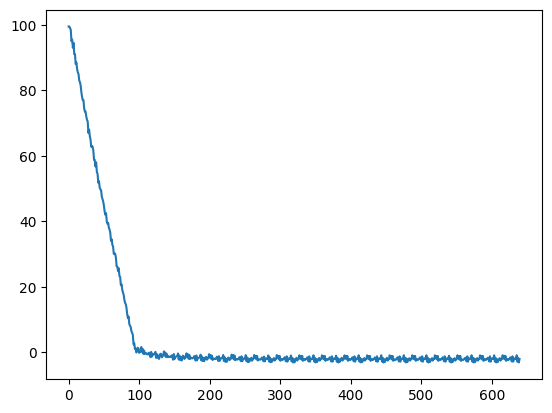

In [78]:
from matplotlib import pyplot as plt

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    # "selection/optimized_heads",
    "selection/optimized_backup_heads",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])

33


(False, False)

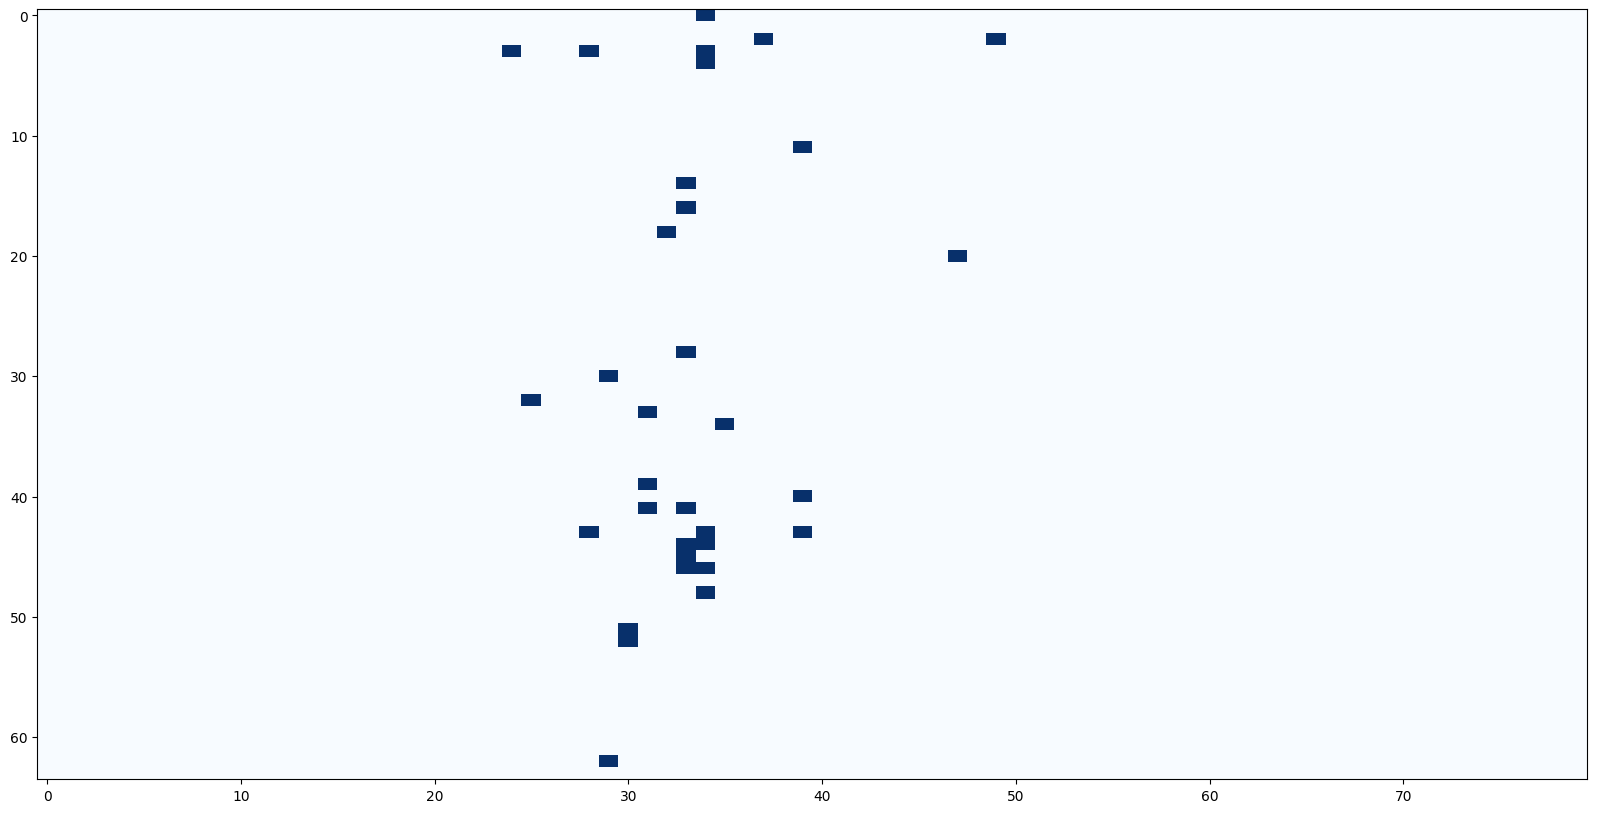

In [81]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

backup_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).to(dtype=torch.int).tolist()
backup_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in backup_heads if layer_idx < 50
]
print(len(backup_heads))

HEADS = backup_heads

(35, 19) in HEADS, (35, 19) in backup_heads

In [82]:
len(heads_selected), len(backup_heads)

(66, 33)

## Validation of the patching effect

In [83]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 256

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    validation_set.append((clean, patch))

2025-08-18 13:30:39 __main__ INFO     Patch category: kitchen appliance, subject: Air fryer, object: Dishwasher
2025-08-18 13:30:39 __main__ INFO     Clean category: sport equipment, subject: Basketball, object: Tennis ball
2025-08-18 13:30:39 __main__ INFO     patch_must_have_options=['Dishwasher', 'Helmet']
2025-08-18 13:30:39 __main__ INFO     clean_must_have_options=['Tennis ball', 'Air fryer']
2025-08-18 13:30:39 __main__ INFO     clean_type_obj='Helmet'
2025-08-18 13:30:39 __main__ INFO     patch_type_obj='Air fryer'
2025-08-18 13:30:39 __main__ INFO     patch_obj_idx=3 | ['Lotion', 'Helmet', 'Skirt', 'Dishwasher', 'Bookshelf', 'Jasmine']
2025-08-18 13:30:39 __main__ INFO     clean_obj_idx=1 | ['Theater', 'Tennis ball', 'Binder', 'Recliner', 'Air fryer', 'Rabbit']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-18 13:30:39 __main__ INFO     Options: Lotion, Helmet, Skirt, Dishwasher, Bookshelf, Jasmine.
Which among these objects mentioned above is a kitchen applianc

In [84]:
len(validation_set)

256

In [46]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair


# clean, patch = copy.deepcopy(validation_set[18])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]
clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)
# failed_case = failed_cases[17]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=sorted(HEADS, key=lambda x: (x[0], x[1])),
    # heads = heads_selected,
    # heads=heads_selected + backup_heads,
    # heads = overlapping_heads,
    # heads=[(35, 19)],
    query_indices={-3: -3, -2: -2, -1: -1},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=2.0
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = after_intervention["target_rank"] - before_intervention["target_rank"]
logger.info(f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} ")
logger.info(f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} ")

clean_logit_delta = after_intervention["clean_logit"] - before_intervention["clean_logit"]
target_logit_delta =  after_intervention["target_logit"] - before_intervention["target_logit"]
logger.info(f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} ")
logger.info(f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} ")

Options: Lily, Dress, Headphones, Apple, Refrigerator, Truck.
Which among these objects mentioned above is a vehicle?
Answer: >> Truck
Options: Mall, Necklace, Headphones, Cherry, Hickory, Bus.
Which among these objects mentioned above is a fruit?
Answer: >> Cherry
2025-08-26 17:09:17 src.selection.optimization INFO     Verifying head behavior...
2025-08-26 17:09:17 src.selection.optimization INFO     Clean Sample >> Ans: Truck


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-26 17:09:23 src.selection.functional DEBUG    Generated full answer: " Truck. 

A truck is a large motor vehicle designed for transporting goods or materials, and it falls under the category of vehicles. The other items listed"
2025-08-26 17:09:23 src.selection.functional DEBUG    Predictions: ['" Truck"[33685] (p=0.844, logit=29.750)', '" The"[576] (p=0.101, logit=27.625)', '" \n"[715] (p=0.025, logit=26.250)', '" Among"[21658] (p=0.014, logit=25.625)', '" \n\n"[4710] (p=0.009, logit=25.250)']
2025-08-26 17:09:23 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-26 17:09:23 src.selection.optimization INFO     Patch Sample >> Ans: Cherry


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-26 17:09:29 src.selection.functional DEBUG    Generated full answer: " The fruit among the objects mentioned is Cherry. 

Cherry is a small, round fruit that typically has a sweet or tart taste and is often eaten"
2025-08-26 17:09:29 src.selection.functional DEBUG    Predictions: ['" Cherry"[44705] (p=0.688, logit=27.500)', '" The"[576] (p=0.196, logit=26.250)', '" Among"[21658] (p=0.056, logit=25.000)', '" \n"[715] (p=0.044, logit=24.750)', '" \n\n"[4710] (p=0.009, logit=23.125)']
2025-08-26 17:09:29 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-26 17:09:30 src.selection.optimization INFO     Caching the query states for the 100 heads
2025-08-26 17:09:30 src.selection.optimization INFO     patch_prediction=['" Cherry"[44705] (p=0.688, logit=27.500)', '" The"[576] (p=0.196, logit=26.250)', '" Among"[21658] (p=0.056, logit=25.000)', '" \n"[715] (p=0.044, logit=24.750)', '" \n\n"[4710] (p=0.009, logit=23.125)']
2025-08-26 17:09:30 src.selection.optimization INFO     clean run
2025-08-26 17:09:30 src.selection.optimization INFO     clean_prediction=['" Truck"[33685] (p=0.844, logit=29.750)', '" The"[576] (p=0.101, logit=27.625)', '" \n"[715] (p=0.025, logit=26.250)', '" Among"[21658] (p=0.014, logit=25.625)', '" \n\n"[4710] (p=0.009, logit=25.250)']
2025-08-26 17:09:30 src.selection.optimization INFO     clean_track=OrderedDict([(33685, (1, PredictedToken(token=' Truck', prob=0.84375, logit=29.75, token_id=33685, metadata=None))), (47290, (26, PredictedToken(token=' Lily', prob=1.800060272216797e-05, logit=19.0, token_id=4

2025-08-26 17:09:31 src.selection.optimization INFO     int_prediction=['" Truck"[33685] (p=0.840, logit=27.875)', '" The"[576] (p=0.069, logit=25.375)', '" Among"[21658] (p=0.053, logit=25.125)', '" \n"[715] (p=0.020, logit=24.125)', '" \n\n"[4710] (p=0.007, logit=23.125)']
2025-08-26 17:09:31 src.selection.optimization INFO     int_track=OrderedDict([(33685, (1, PredictedToken(token=' Truck', prob=0.83984375, logit=27.875, token_id=33685, metadata=None))), (47290, (14, PredictedToken(token=' Lily', prob=0.00010347366333007812, logit=18.875, token_id=47290, metadata=None))), (8162, (26, PredictedToken(token=' Apple', prob=4.315376281738281e-05, logit=18.0, token_id=8162, metadata=None))), (11203, (41, PredictedToken(token=' Head', prob=1.0907649993896484e-05, logit=16.625, token_id=11203, metadata=None))), (74158, (377, PredictedToken(token=' Refriger', prob=3.259629011154175e-08, logit=10.8125, token_id=74158, metadata=None))), (28218, (774, PredictedToken(token=' Dress', prob=9.3132

In [45]:
from src.selection.functional import cache_q_projections, verify_head_patterns
from typing import Literal
from src.functional import PatchSpec, interpret_logits
from src.hooking.llama_attention import LlamaAttentionPatcher
import baukit
import types


def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
    mt.config._attn_implementation = attn_implementation
    for layer_idx in range(mt.config.num_hidden_layers):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.config._attn_implementation = attn_implementation


##########################################################
query_indices = [-3, -2, -1]
heads = heads_selected
##########################################################

mt.reset_forward()
set_attn_implementation(mt, "eager")

clean_sample = failed_case["clean_sample"]
patch_sample = failed_case["patch_sample"]

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

verify_head_patterns(
    prompt=patch_sample.prompt(),
    tokenized_prompt=patch_tokenized,
    pivot=patch_sample.subj,
    options=patch_sample.options,
    mt=mt,
    heads=heads,
    query_index=-1,
)

verify_head_patterns(
    prompt=clean_sample.prompt(),
    tokenized_prompt=clean_tokenized,
    pivot=clean_sample.subj,
    options=clean_sample.options,
    mt=mt,
    heads=heads,
    query_index=-1,
)

query_locations = [
    (layer_idx, head_idx, query_idx)
    for layer_idx, head_idx in heads
    for query_idx in query_indices
]

cached_q_states, patch_output = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    return_output=True,
)
q_proj_patches = []
for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_idx,
            ),
            patch=q_proj,
        )
    )

patch_logits = patch_output.logits[:, -1, :].squeeze()
patch_predictions = interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
)
logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")


mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layers_to_heads = {}
for layer_idx, head_idx in heads:
    if layer_idx not in layers_to_heads:
        layers_to_heads[layer_idx] = []
    layers_to_heads[layer_idx].append(head_idx)

layers_to_q_patches = {}
for (layer_idx, head_idx, query_idx), patch in cached_q_states.items():
    if layer_idx not in layers_to_q_patches:
        layers_to_q_patches[layer_idx] = []
    layers_to_q_patches[layer_idx].append((head_idx, query_idx, patch))

attention_patterns = {}
head_contributions = {}
for layer_idx, head_indices in layers_to_heads.items():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    attention_patterns[layer_idx] = {}
    head_contributions[layer_idx] = {}

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=head_indices,
            store_attn_matrices=attention_patterns[layer_idx],
            store_head_contributions=head_contributions[layer_idx],
            query_patches=layers_to_q_patches[layer_idx],
            amplify_contributions=[
                (head_idx, q_idx, 2.0)
                for head_idx in head_indices
                for q_idx in query_indices
            ],
            # value_weighted=True,
        ),
        attn_block,
    )


output = mt._model(**clean_tokenized)
int_logits = output.logits[:, -1, :].squeeze()
int_pred = interpret_logits(
    tokenizer=mt,
    logits=int_logits,
)

logger.info(f"int_prediction={[str(pred) for pred in int_pred]}")

mt.reset_forward()
set_attn_implementation(mt, "eager")

NameError: name 'failed_case' is not defined

In [261]:
from src.selection.functional import visualize_attn_matrix

attn_matrix = []
for layer_idx in attention_patterns:
    for head_idx in attention_patterns[layer_idx]:
        attn_matrix.append(attention_patterns[layer_idx][head_idx].cpu())
attn_matrix = torch.stack(attn_matrix).squeeze().mean(dim=0)

visualize_attn_matrix(
    attn_matrix = attn_matrix,
    tokens = [mt.tokenizer.decode(t) for t in clean_tokenized["input_ids"][0]]
)



In [100]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=heads_selected,
        # heads=backup_heads,
        heads=heads_selected + backup_heads,
        # heads = overlapping_heads,
        query_indices={-3: -3, -2: -2, -1: -1},
        verify_head_behavior_on=None,
        # amplification_scale=1.5
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-08-18 13:44:11 src.selection.optimization INFO     Caching the query states for the 99 heads
2025-08-18 13:44:12 src.selection.optimization INFO     patch_prediction=['" Dish"[49268] (p=0.734, logit=21.125)', '" The"[578] (p=0.100, logit=19.125)', '" A"[362] (p=0.068, logit=18.750)', '" Among"[22395] (p=0.047, logit=18.375)', '" dishwasher"[61433] (p=0.006, logit=16.375)']
2025-08-18 13:44:12 src.selection.optimization INFO     clean run
2025-08-18 13:44:12 src.selection.optimization INFO     clean_prediction=['" Tennis"[58251] (p=0.824, logit=21.250)', '" The"[578] (p=0.067, logit=18.750)', '" Among"[22395] (p=0.046, logit=18.375)', '" A"[362] (p=0.017, logit=17.375)', '" ("[320] (p=0.004, logit=16.000)']
2025-08-18 13:44:12 src.selection.optimization INFO     clean_track=OrderedDict([(58251, (1, PredictedToken(token=' Tennis', prob=0.82421875, logit=21.25, token_id=58251, metadata=None))), (91263, (11, PredictedToken(token=' Binder', prob=0.0016937255859375, logit=15.0625, token

In [101]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [102]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 27.3594 ± 70.8989
target_rank_delta: -238.6797 ± 441.9390
clean_rank_after_intervention: 28.3594 ± 70.8989
target_rank_after_intervention: 1.9883 ± 2.2421


In [103]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -6.1606 ± 2.5276
target_logit_delta: 8.0649 ± 3.3183
clean_logit_after_intervention: 15.3936 ± 2.4665
target_logit_after_intervention: 19.7424 ± 1.6541


In [104]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.7265625

In [105]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.7734 (198/256)


In [252]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(
        "Track: ",
        clean_sample.metadata["track_type_obj"], " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", clean_sample.obj, f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Options: Camera, Potato, Lavender, Stool, Refrigerator, Tractor.
Which among these objects mentioned above is a vegetable?
Answer: >> Potato
----------------------------------------------------------------------------------------------------
Track:  Refrigerator  | Token" Refriger"
Clean: Potato (Token:  Potato)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Potato\"[78703] (p=0.793, logit=21.750)",
    "\" Tr\"[1183] (p=0.000, logit=12.312)",
    "\" St\"[800] (p=0.000, logit=11.875)",
    "\" Camera\"[14669] (p=0.000, logit=10.938)",
    "\" Lav\"[43950] (p=0.000, logit=10.875)",
    "\" Refriger\"[75258] (p=0.000, logit=9.500)"
]
Intervened Track: [
    "\" Potato\"[78703] (p=0.855, logit=22.000)",
    "\" St\"[800] (p=0.002, logit=15.812)",
    "\" Lav\"[43950] (p=0.001, logit=15.438)",
    "\" Tr\"[1183] (p=0.000, logit=14.438)",
    "\" Refriger\"[75258] (p=0.000, logit=13.938)",
    "\" Ca

In [113]:
failed_case = failed_cases[10]
clean_sample = failed_case["clean_sample"]
patch_sample = failed_case["patch_sample"]

clean_tokenized = mt.tokenizer(clean_sample.prompt(), return_tensors="pt")
patch_tokenized = mt.tokenizer(patch_sample.prompt(), return_tensors="pt")


## Heads found with different tasks

Processing task: select_one
Optimal head mask shape for select_one: torch.Size([80, 64])
Processing task: select_order
Optimal head mask shape for select_order: torch.Size([80, 64])


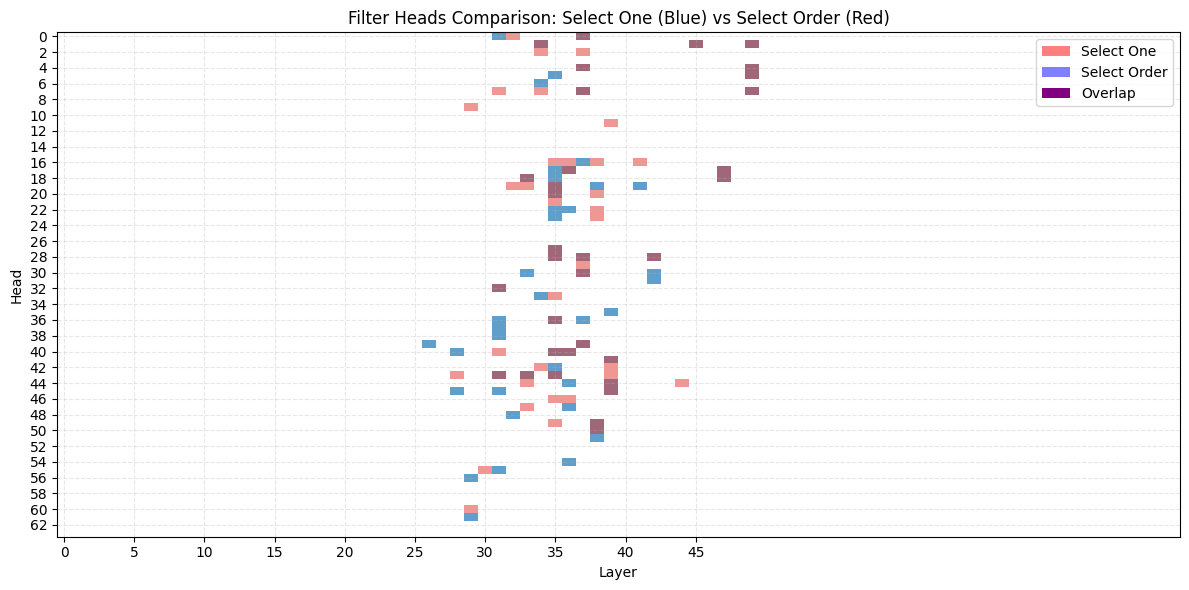

Total heads for select_one: 66
Total heads for select_order: 65
Overlapping heads: 33
Overlapping positions: [(31, 32), (31, 43), (33, 18), (33, 43), (34, 1), (35, 19), (35, 20), (35, 27), (35, 28), (35, 36), (35, 40), (35, 43), (36, 17), (36, 40), (37, 0), (37, 4), (37, 7), (37, 28), (37, 30), (37, 39), (38, 49), (38, 50), (39, 41), (39, 44), (39, 45), (42, 28), (45, 1), (47, 17), (47, 18), (49, 1), (49, 4), (49, 5), (49, 7)]


In [256]:
task_names = [
    "select_one", 
    "select_order"
]
heads = {task_name: [] for task_name in task_names}
colors = {
    "select_one": "Blues",
    "select_order": "Reds",
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create combined mask for overlapping heads
combined_mask = np.zeros((mt.config.num_attention_heads, mt.n_layer)) 

for i, task_name in enumerate(task_names):
    print("Processing task:", task_name)

    optimized_path = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR,
        "selection/optimized_heads",
        mt.name.split("/")[-1],
        f"{task_name}.npz",
    )
    optimization_results = np.load(optimized_path, allow_pickle=True)
    optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(
        torch.float32
    )
    print(f"Optimal head mask shape for {task_name}: {optimal_head_mask.shape}")
    
    # Get head positions
    task_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
    task_heads = [
        (layer_idx, head_idx) for layer_idx, head_idx in task_heads if layer_idx < 50
    ]
    heads[task_name] = task_heads
    
    # Prepare mask for visualization
    optimal_head_mask = optimal_head_mask.round()
    optimal_head_mask[50:] = 0
    
    # Create a masked array to handle transparency properly
    mask_array = optimal_head_mask.T.numpy()
    masked_data = np.ma.masked_where(mask_array == 0, mask_array)
    
    # Plot with proper alpha blending
    im = ax.imshow(
        masked_data,
        cmap=colors[task_name],
        aspect="auto",
        vmin=0,
        vmax=1.5,
        alpha=0.8 if i == 0 else 0.5,  # Different alphas for better visibility
        interpolation='nearest'
    )
    
    # Track overlaps (optional)
    combined_mask += mask_array * (i + 1)

# Add labels and formatting
ax.set_xlabel("Layer")
ax.set_ylabel("Head")
ax.set_title("Filter Heads Comparison: Select One (Blue) vs Select Order (Red)")

# Add grid for clarity
ax.set_xticks(np.arange(0, 50, 5))
ax.set_yticks(np.arange(0, optimal_head_mask.shape[1], 2))
ax.grid(True, alpha=0.3, linestyle='--')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.5, label='Select One'),
    Patch(facecolor='blue', alpha=0.5, label='Select Order'),
    Patch(facecolor='purple', alpha=1, label='Overlap')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Optional: Print overlap statistics
overlapping_heads = []
for task1_head in heads["select_one"]:
    if task1_head in heads["select_order"]:
        overlapping_heads.append(task1_head)

print(f"Total heads for select_one: {len(heads['select_one'])}")
print(f"Total heads for select_order: {len(heads['select_order'])}")
print(f"Overlapping heads: {len(overlapping_heads)}")
if overlapping_heads:
    print(f"Overlapping positions: {overlapping_heads}")

In [257]:
# find intersection of heads
overlapping_heads = set(heads[task_names[0]]) & set(heads[task_names[1]])
print(f"Intersection Heads: {len(overlapping_heads)}")

Intersection Heads: 33
